# Feature Engineering Performance Comparison

This notebook profiles three implementations of the feature engineering pipeline:
1. **Pandas** (original Python implementation)
2. **Polars** (Rust-based DataFrame library)
3. **FastPPI** (compiled C binary)

## Setup


In [1]:
import sys
import time
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

# Import FastPPI runner
from fastPPI import run_binary

# Import the original function
from feature_engineering import preprocess_data

# Import Polars version
from feature_engineering_polars import preprocess_data_polars

# CSV file path
csv_path = "example_data.csv"

print("✓ Imports successful")
print(f"CSV file: {csv_path}")


✓ Imports successful
CSV file: example_data.csv


## 1. Profile Pandas Implementation


In [2]:
def profile_pandas(n_iterations=100, warmup=10):
    """Profile the pandas implementation."""
    # Warmup
    for _ in range(warmup):
        _ = preprocess_data(csv_path)
    
    # Actual timing
    times = []
    results = None
    
    for i in range(n_iterations):
        start = time.perf_counter()
        X, y = preprocess_data(csv_path)
        end = time.perf_counter()
        times.append((end - start) * 1000)  # Convert to milliseconds
        if i == 0:
            results = (X, y)
    
    return {
        'mean_ms': np.mean(times),
        'std_ms': np.std(times),
        'min_ms': np.min(times),
        'max_ms': np.max(times),
        'median_ms': np.median(times),
        'times': times,
        'results': results
    }

print("Profiling Pandas implementation...")
pandas_stats = profile_pandas(n_iterations=100)

print(f"\n📊 Pandas Results:")
print(f"  Mean:   {pandas_stats['mean_ms']:.3f} ms")
print(f"  Median: {pandas_stats['median_ms']:.3f} ms")
print(f"  Std:    {pandas_stats['std_ms']:.3f} ms")
print(f"  Min:    {pandas_stats['min_ms']:.3f} ms")
print(f"  Max:    {pandas_stats['max_ms']:.3f} ms")

X_pandas, y_pandas = pandas_stats['results']
print(f"\n✓ Processed {len(X_pandas)} rows with {len(X_pandas.columns)} features")


Profiling Pandas implementation...

📊 Pandas Results:
  Mean:   0.972 ms
  Median: 0.958 ms
  Std:    0.134 ms
  Min:    0.800 ms
  Max:    1.487 ms

✓ Processed 100 rows with 6 features


## 2. Profile Polars Implementation


In [7]:
def profile_polars(n_iterations=100, warmup=10):
    """Profile the Polars implementation."""
    # Warmup
    for _ in range(warmup):
        _ = preprocess_data_polars(csv_path)
    
    # Actual timing
    times = []
    results = None
    
    for i in range(n_iterations):
        start = time.perf_counter()
        X, y = preprocess_data_polars(csv_path)
        end = time.perf_counter()
        times.append((end - start) * 1000)  # Convert to milliseconds
        if i == 0:
            results = (X, y)
    
    return {
        'mean_ms': np.mean(times),
        'std_ms': np.std(times),
        'min_ms': np.min(times),
        'max_ms': np.max(times),
        'median_ms': np.median(times),
        'times': times,
        'results': results
    }

print("Profiling Polars implementation...")
polars_stats = profile_polars(n_iterations=100)

print(f"\n📊 Polars Results:")
print(f"  Mean:   {polars_stats['mean_ms']:.3f} ms")
print(f"  Median: {polars_stats['median_ms']:.3f} ms")
print(f"  Std:    {polars_stats['std_ms']:.3f} ms")
print(f"  Min:    {polars_stats['min_ms']:.3f} ms")
print(f"  Max:    {polars_stats['max_ms']:.3f} ms")

X_polars, y_polars = polars_stats['results']
print(f"\n✓ Processed {len(X_polars)} rows with {len(X_polars.columns)} features")


Profiling Polars implementation...

📊 Polars Results:
  Mean:   0.470 ms
  Median: 0.447 ms
  Std:    0.142 ms
  Min:    0.294 ms
  Max:    1.371 ms

✓ Processed 100 rows with 6 features


## 3. Profile FastPPI Compiled Binary

The FastPPI binary now properly handles string inputs like `csv_path` by converting the encoded character array back to a `char*` string for use with `pandas_read_csv`.


In [6]:
import os

# Set up library path for dynamic linking
lib_path = Path.cwd().parent / "c_implementations" / "lib"
if lib_path.exists():
    if 'DYLD_LIBRARY_PATH' in os.environ:
        os.environ['DYLD_LIBRARY_PATH'] = f"{lib_path}:{os.environ['DYLD_LIBRARY_PATH']}"
    else:
        os.environ['DYLD_LIBRARY_PATH'] = str(lib_path)

# Binary path - use the fixed binary
binary_path = "feature_engineering_binary_optimized.dylib"
metadata_path = "feature_engineering_binary_optimized.dylib_metadata.json"

def profile_fastppi(n_iterations=100, warmup=10):
    """Profile the FastPPI compiled binary."""
    # Warmup
    for _ in range(warmup):
        try:
            _ = run_binary(binary_path, metadata_path=metadata_path, csv_path=csv_path)
        except Exception as e:
            print(f"Warning during warmup: {e}")
    
    # Actual timing
    times = []
    results = None
    errors = 0
    
    for i in range(n_iterations):
        try:
            start = time.perf_counter()
            output = run_binary(binary_path, metadata_path=metadata_path, csv_path=csv_path)
            end = time.perf_counter()
            times.append((end - start) * 1000)  # Convert to milliseconds
            if i == 0:
                results = output
        except Exception as e:
            errors += 1
            if errors == 1:
                print(f"Error during profiling: {e}")
    
    if not times:
        return {
            'mean_ms': np.nan,
            'std_ms': np.nan,
            'min_ms': np.nan,
            'max_ms': np.nan,
            'median_ms': np.nan,
            'times': [],
            'results': None,
            'errors': errors
        }
    
    return {
        'mean_ms': np.mean(times),
        'std_ms': np.std(times),
        'min_ms': np.min(times),
        'max_ms': np.max(times),
        'median_ms': np.median(times),
        'times': times,
        'results': results,
        'errors': errors
    }

print("Profiling FastPPI compiled binary...")
fastppi_stats = profile_fastppi(n_iterations=100)

if fastppi_stats['times']:
    print(f"\n📊 FastPPI Results:")
    print(f"  Mean:   {fastppi_stats['mean_ms']:.3f} ms")
    print(f"  Median: {fastppi_stats['median_ms']:.3f} ms")
    print(f"  Std:    {fastppi_stats['std_ms']:.3f} ms")
    print(f"  Min:    {fastppi_stats['min_ms']:.3f} ms")
    print(f"  Max:    {fastppi_stats['max_ms']:.3f} ms")
    if fastppi_stats.get('errors', 0) > 0:
        print(f"  Errors: {fastppi_stats['errors']}/{100}")
    
    print(f"\n✓ FastPPI execution successful")
    if fastppi_stats['results'] is not None:
        print(f"  Output type: {type(fastppi_stats['results'])}")
        if isinstance(fastppi_stats['results'], dict):
            print(f"  Output keys: {list(fastppi_stats['results'].keys())}")
else:
    print(f"\n❌ FastPPI profiling failed with {fastppi_stats.get('errors', 0)} errors")


Profiling FastPPI compiled binary...

📊 FastPPI Results:
  Mean:   0.435 ms
  Median: 0.404 ms
  Std:    0.139 ms
  Min:    0.325 ms
  Max:    1.179 ms

✓ FastPPI execution successful
  Output type: <class 'dict'>
  Output keys: ['output_0', 'output_1']


## 4. Comparison Summary


In [8]:
# Create comparison DataFrame
comparison_data = {
    'Implementation': ['Pandas', 'Polars', 'FastPPI'],
    'Mean (ms)': [
        pandas_stats['mean_ms'],
        polars_stats['mean_ms'],
        fastppi_stats['mean_ms'] if fastppi_stats['times'] else np.nan
    ],
    'Median (ms)': [
        pandas_stats['median_ms'],
        polars_stats['median_ms'],
        fastppi_stats['median_ms'] if fastppi_stats['times'] else np.nan
    ],
    'Std (ms)': [
        pandas_stats['std_ms'],
        polars_stats['std_ms'],
        fastppi_stats['std_ms'] if fastppi_stats['times'] else np.nan
    ],
    'Min (ms)': [
        pandas_stats['min_ms'],
        polars_stats['min_ms'],
        fastppi_stats['min_ms'] if fastppi_stats['times'] else np.nan
    ],
    'Max (ms)': [
        pandas_stats['max_ms'],
        polars_stats['max_ms'],
        fastppi_stats['max_ms'] if fastppi_stats['times'] else np.nan
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Calculate speedups relative to Pandas
pandas_mean = pandas_stats['mean_ms']
comparison_df['Speedup vs Pandas'] = pandas_mean / comparison_df['Mean (ms)']

print("=" * 80)
print("PERFORMANCE COMPARISON")
print("=" * 80)
print()
print(comparison_df.to_string(index=False))
print()

# Summary
if fastppi_stats['times']:
    print("📈 Speedups:")
    print(f"  Polars vs Pandas:  {polars_stats['mean_ms'] / pandas_mean:.2f}x")
    print(f"  FastPPI vs Pandas: {pandas_mean / fastppi_stats['mean_ms']:.2f}x")
    print(f"  FastPPI vs Polars: {polars_stats['mean_ms'] / fastppi_stats['mean_ms']:.2f}x")
else:
    print("⚠️  FastPPI results unavailable - check errors above")


PERFORMANCE COMPARISON

Implementation  Mean (ms)  Median (ms)  Std (ms)  Min (ms)  Max (ms)  Speedup vs Pandas
        Pandas   0.972393     0.957834  0.134429  0.800125  1.487292           1.000000
        Polars   0.469739     0.446916  0.141781  0.294375  1.370542           2.070073
       FastPPI   0.435090     0.404125  0.139231  0.325416  1.178625           2.234925

📈 Speedups:
  Polars vs Pandas:  0.48x
  FastPPI vs Pandas: 2.23x
  FastPPI vs Polars: 1.08x


## 5. Visualization


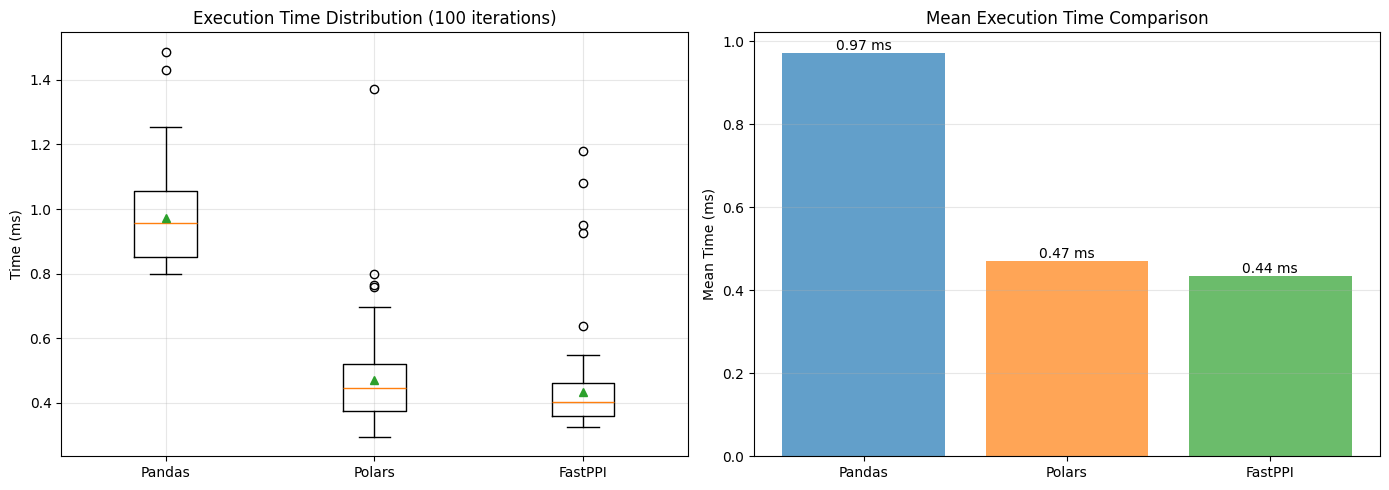

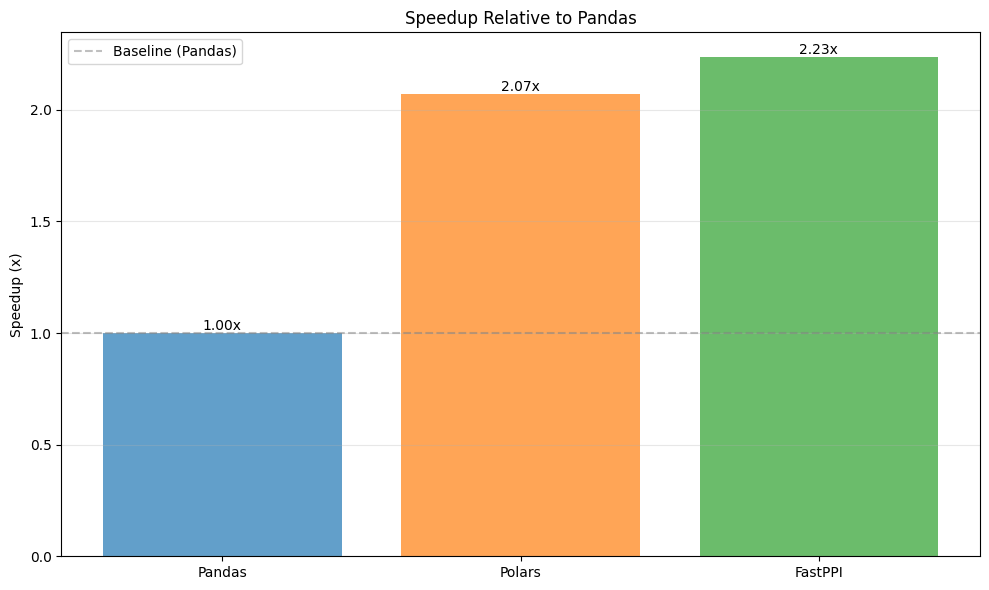

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of timing distributions
axes[0].boxplot(
    [pandas_stats['times'], polars_stats['times'], fastppi_stats['times'] if fastppi_stats['times'] else []],
    labels=['Pandas', 'Polars', 'FastPPI'],
    showmeans=True
)
axes[0].set_ylabel('Time (ms)')
axes[0].set_title('Execution Time Distribution (100 iterations)')
axes[0].grid(True, alpha=0.3)

# Bar chart of mean times
mean_times = [
    pandas_stats['mean_ms'],
    polars_stats['mean_ms'],
    fastppi_stats['mean_ms'] if fastppi_stats['times'] else 0
]
labels = ['Pandas', 'Polars', 'FastPPI']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bars = axes[1].bar(labels, mean_times, color=colors, alpha=0.7)
axes[1].set_ylabel('Mean Time (ms)')
axes[1].set_title('Mean Execution Time Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mean_time in zip(bars, mean_times):
    if mean_time > 0:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{mean_time:.2f} ms',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Speedup comparison
if fastppi_stats['times']:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    speedups = [
        1.0,  # Pandas baseline
        pandas_mean / polars_stats['mean_ms'],  # Polars speedup
        pandas_mean / fastppi_stats['mean_ms']  # FastPPI speedup
    ]
    
    bars = ax.bar(labels, speedups, color=colors, alpha=0.7)
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline (Pandas)')
    ax.set_ylabel('Speedup (x)')
    ax.set_title('Speedup Relative to Pandas')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend()
    
    # Add value labels
    for bar, speedup in zip(bars, speedups):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{speedup:.2f}x',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


## Notes

- **Pandas**: Original Python implementation using pandas library
- **Polars**: Rust-based DataFrame library with lazy evaluation
- **FastPPI**: Compiled C binary generated from the pandas code

### Considerations:
- CSV I/O time is included in all measurements
- FastPPI binary includes the compiled pandas operations
